# Предсказание стоимости жилья

В проекте обучается две модели линейной регрессии на данных о жилье в Калифорнии в 1990 году. 

Ссылка на датасет на kaggle: https://www.kaggle.com/datasets/camnugent/california-housing-prices?datasetId=5227&searchQuery=spar

В колонках датасета содержатся следующие данные:

   * `longitude` — широта;
   * `latitude` — долгота;
   * `housing_median_age` — медианный возраст жителей жилого массива;
   * `total_rooms` — общее количество комнат в домах жилого массива;
   * `total_bedrooms` — общее количество спален в домах жилого массива;
   * `population` — количество человек, которые проживают в жилом массиве;
   * `households` — количество домовладений в жилом массиве;
   * `median_income` — медианный доход жителей жилого массива;
   * `median_house_value` — медианная стоимость дома в жилом массиве;
   * `ocean_proximity` — близость к океану.

На основе данных предсказана медианная стоимость дома в жилом массиве — `median_house_value`. <br>
Для оценки качества моделей используются метрики RMSE, MAE и R2.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pyspark

from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
import pyspark.sql as sparksql

from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [2]:
RANDOM_SEED = 42

## Обзор данных

In [3]:
spark = SparkSession.builder \
                    .master("local") \
                    .appName("California_Housing") \
                    .getOrCreate()

In [4]:
df = spark.read.csv('/datasets/housing.csv', inferSchema=True, header='true')
df.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



In [5]:
df.show(10)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

In [6]:
# проверка на пропуски
columns = df.columns

for column in columns:
    check_columns = F.col(column).isNull()
    print(column, df.filter(check_columns).count())

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 207
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


In [7]:
numeric_columns = ['housing_median_age', 'total_rooms',
                   'total_bedrooms','population', 'households',
                   'median_income', 'median_house_value']

df.describe(numeric_columns).show(truncate=12)

+-------+------------------+------------+--------------+------------+------------+-------------+------------------+
|summary|housing_median_age| total_rooms|total_bedrooms|  population|  households|median_income|median_house_value|
+-------+------------------+------------+--------------+------------+------------+-------------+------------------+
|  count|             20640|       20640|         20433|       20640|       20640|        20640|             20640|
|   mean|      28.639486...|2635.7630...|  537.87055...|1425.4767...|499.53968...| 3.8706710...|      206855.81...|
| stddev|      12.585557...|2181.6152...|  421.38507...|1132.4621...|382.32975...| 1.8998217...|      115395.61...|
|    min|               1.0|         2.0|           1.0|         3.0|         1.0|       0.4999|           14999.0|
|    max|              52.0|     39320.0|        6445.0|     35682.0|      6082.0|      15.0001|          500001.0|
+-------+------------------+------------+--------------+------------+---

In [8]:
df.describe(numeric_columns).toPandas()

,summary,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,count,20640,20640,20433,20640,20640,20640,20640
1,mean,28.639486434108527,2635.7630813953488,537.8705525375618,1425.4767441860465,499.5396802325581,3.8706710029070246,206855.81690891474
2,stddev,12.58555761211163,2181.6152515827944,421.38507007403115,1132.46212176534,382.3297528316098,1.899821717945263,115395.61587441359
3,min,1.0,2.0,1.0,3.0,1.0,0.4999,14999.0
4,max,52.0,39320.0,6445.0,35682.0,6082.0,15.0001,500001.0


In [9]:
df.dtypes

[('longitude', 'double'),
 ('latitude', 'double'),
 ('housing_median_age', 'double'),
 ('total_rooms', 'double'),
 ('total_bedrooms', 'double'),
 ('population', 'double'),
 ('households', 'double'),
 ('median_income', 'double'),
 ('median_house_value', 'double'),
 ('ocean_proximity', 'string')]

In [10]:
print(pd.DataFrame(df.dtypes, columns=['column', 'type']).head(10))

               column    type
0           longitude  double
1            latitude  double
2  housing_median_age  double
3         total_rooms  double
4      total_bedrooms  double
5          population  double
6          households  double
7       median_income  double
8  median_house_value  double
9     ocean_proximity  string


### Вывод:

1. Датасет состоит из 10 столбцов и 20 640 строк;
2. В столбце `total_bedrooms` обнаружено 207 пропущенных значений, которые необходимо обработать;
3. Столбец `ocean_proximity` категориальный и имеет тип данных string, остальные количественные и тип double;
4. Целевой признак - `median_house_value`.

## Подготовка данных

### Исследовательский анализ данных

In [11]:
#pandas_df = df.toPandas()

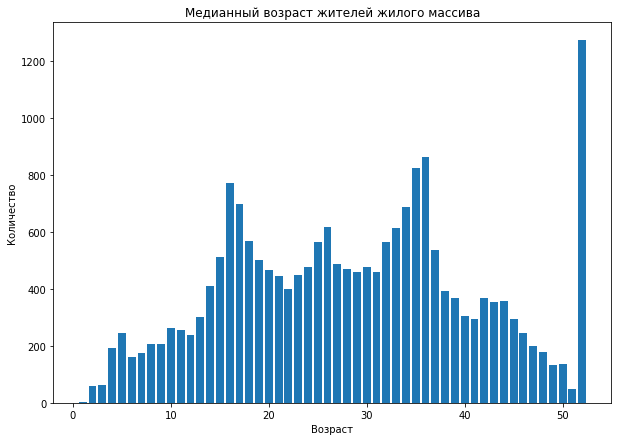

In [12]:
median_age_unique = df.groupBy('housing_median_age').count().collect()

# Creating dataset
median_age_label = [item[0] for item in median_age_unique]
median_age_count = [item[1] for item in median_age_unique]

# Creating plot
fig = plt.figure(figsize =(10, 7))
plt.title('Медианный возраст жителей жилого массива')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.bar(median_age_label, median_age_count);

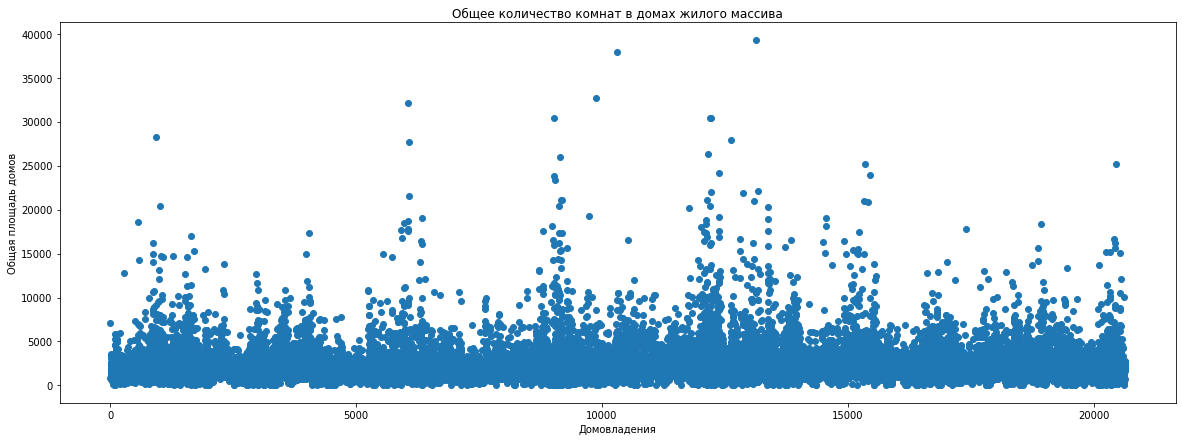

In [13]:
total_rooms_y = list(df.select('total_rooms').collect())
total_rooms_x = np.arange(0, len(total_rooms_y), 1, dtype=int)

# Creating plot
fig = plt.figure(figsize =(20, 7))

plt.title('Общее количество комнат в домах жилого массива')
plt.xlabel('Домовладения')
plt.ylabel('Общая площадь домов')
plt.scatter(x=total_rooms_x, y=total_rooms_y);

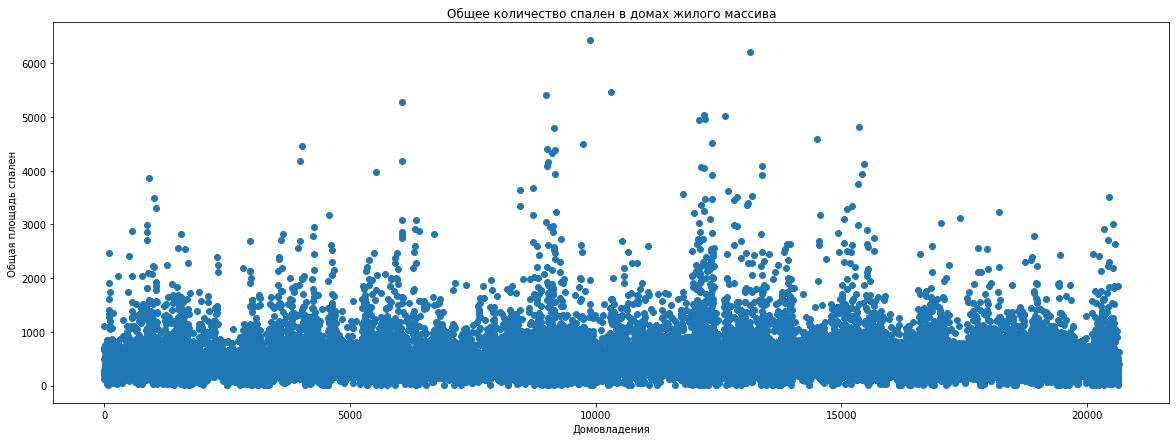

In [14]:
total_bedrooms_y = list(df.select('total_bedrooms').collect())
total_bedrooms_x = np.arange(0, len(total_bedrooms_y), 1, dtype=int)

# Creating plot
fig = plt.figure(figsize =(20, 7))

plt.title('Общее количество спален в домах жилого массива')
plt.xlabel("Домовладения")
plt.ylabel('Общая площадь спален')
plt.scatter(x=total_bedrooms_x, y=total_bedrooms_y);

#plt.show()

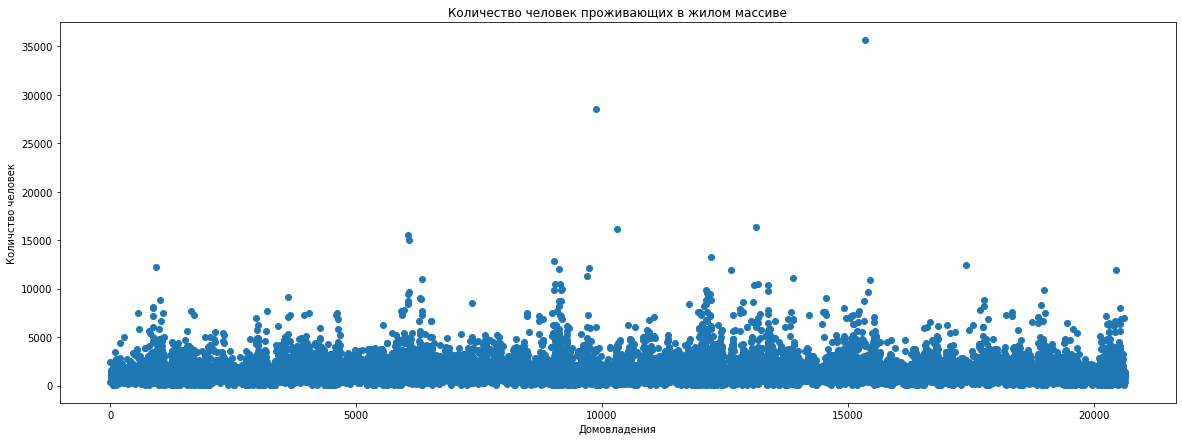

In [15]:
population_y = list(df.select('population').collect())
population_x = np.arange(0, len(population_y), 1, dtype=int)

# Creating plot
fig = plt.figure(figsize =(20, 7))

plt.title('Количество человек проживающих в жилом массиве')
plt.xlabel("Домовладения")
plt.ylabel('Количство человек')
plt.scatter(x=population_x, y=population_y);

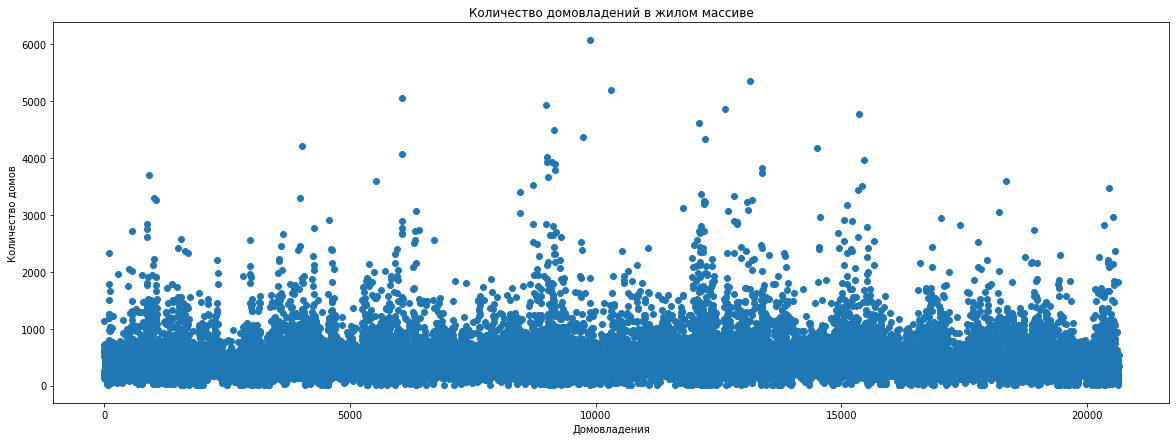

In [16]:
households_y = list(df.select('households').collect())
households_x = np.arange(0, len(households_y), 1, dtype=int)

# Creating plot
fig = plt.figure(figsize =(20, 7))

plt.title('Количество домовладений в жилом массиве')
plt.xlabel("Домовладения")
plt.ylabel('Количество домов')
plt.scatter(x=households_x, y=households_y);

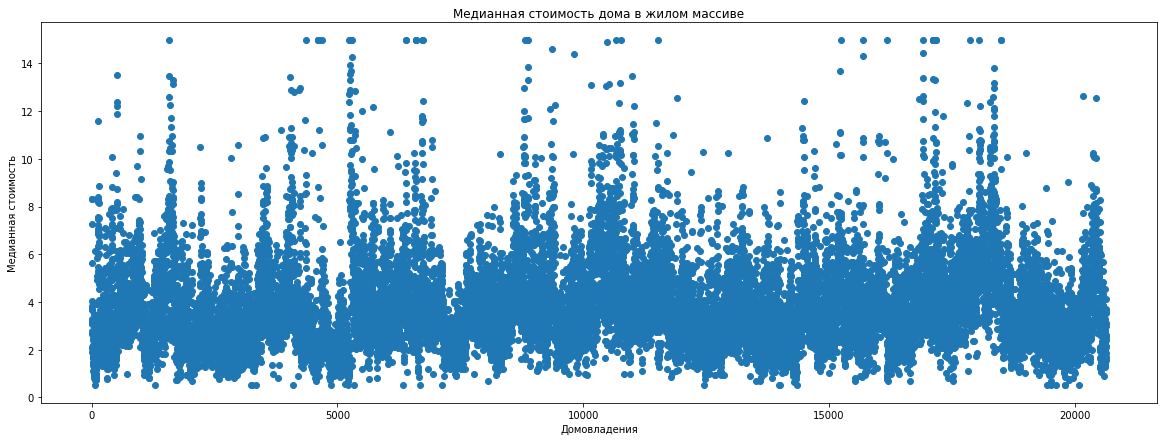

In [17]:
median_income_y = list(df.select('median_income').collect())
median_income_x = np.arange(0, len(median_income_y), 1, dtype=int)

# Creating plot
fig = plt.figure(figsize =(20, 7))

plt.title('Медианная стоимость дома в жилом массиве')
plt.xlabel("Домовладения")
plt.ylabel('Медианная стоимость')
plt.scatter(x=median_income_x, y=median_income_y);

1. Значения в столбце `housing_median_age` распределены нормально, присутствуют пиковые значения.
2. В колонках `total_rooms`, `total_bedrooms`, `population`,`households`, `median_income` данные распределены нормально, скошены вправо и имеют аномальные значения.

### Замена пропусков на среднее значение

In [18]:
mean = df.select(F.mean('total_bedrooms')).collect()[0][0]

In [19]:
df = df.na.fill({'total_bedrooms': mean})

### Создание новых признаков


* Отношение количества комнат `total_rooms` к количеству домовладений `households`.
* Отношение количества жителей `population` к количеству домовладений `households`.
* Отношение количества спален `total_bedrooms` к общему количеству комнат `total_rooms`.

In [20]:
df = df.withColumn('rooms_per_household',
                   F.col('total_rooms') / F.col('households'))
df = df.withColumn('population_in_household',
                   F.col('population') / F.col('households'))
df = df.withColumn('bedroom_index',
                   F.col('total_bedrooms') / F.col('total_rooms'))

### Преобразование данных

In [21]:
categorical_cols = ['ocean_proximity']

numerical_cols  = ['longitude','latitude','housing_median_age', \
                   'total_rooms','total_bedrooms', 'population', \
                   'households','median_income','rooms_per_household',\
                   'population_in_household', 'bedroom_index']

target = "median_house_value"

In [22]:
stages = []

for categoricalCol in categorical_cols:
    #преобразование категориальных колонок в бинарные вектора благодаря строковому преобразователю
    indexer = StringIndexer(inputCols=categorical_cols,
                        outputCols=[c+'_idx' for c in categorical_cols])

    encoder = OneHotEncoder(inputCols=[c+'_idx' for c in categorical_cols],
                        outputCols=[c+'_ohe' for c in categorical_cols])

    categorical_assembler = \
        VectorAssembler(inputCols=[c+'_ohe' for c in categorical_cols],
                                        outputCol="categorical_features")

numeric_assembler = VectorAssembler(inputCols=numerical_cols, outputCol='numeric_features')

standardScaler = StandardScaler(inputCol='numeric_features', outputCol='numeric_features_scaler')

features = ['categorical_features', 'numeric_features_scaler']

final_assembler = VectorAssembler(inputCols = features, outputCol='features')

stages += [indexer, encoder, categorical_assembler, numeric_assembler, standardScaler, final_assembler]

In [23]:
#indexer = StringIndexer(inputCols=categorical_cols,
#                        outputCols=[c+'_idx' for c in categorical_cols])
#
#train = indexer.fit(train).transform(train)
#
#cols = [c for c in train.columns for i in categorical_cols if (c.startswith(i))]

In [24]:
#df.select(cols).show(5)

In [25]:
#encoder = OneHotEncoder(inputCols=[c+'_idx' for c in categorical_cols],
#                        outputCols=[c+'_ohe' for c in categorical_cols])
#df = encoder.fit(df).transform(df)
#
#cols = [c for c in df.columns for i in categorical_cols if (c.startswith(i))]

In [26]:
#df.select(cols).show(5)

In [27]:
#categorical_assembler = \
#        VectorAssembler(inputCols=[c+'_ohe' for c in categorical_cols],
#                                        outputCol="categorical_features")
#df = categorical_assembler.transform(df)

In [28]:
#numeric_assembler = VectorAssembler(inputCols=numerical_cols, outputCol='numeric_features')
#df = numeric_assembler.transform(df)

In [29]:
#df.select(['numeric_features']).show(5)

In [30]:
#standardScaler = StandardScaler(inputCol='numeric_features', outputCol='numeric_features_scaler')
#df = standardScaler.fit(df).transform(df)

In [31]:
#df.select(['numeric_features_scaler']).show(5)

In [32]:
#features = ['categorical_features', 'numeric_features_scaler']
#
#final_assembler = VectorAssembler(inputCols = features, outputCol='features')
#df = final_assembler.transform(df)

In [33]:
#df.select('features').show(5)

## Обучение моделей

### Разделение данных на обучающую и тестовую выборки

In [34]:
train, test = df.randomSplit([0.7, 0.3], seed = 42)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 14509
Test Dataset Count: 6131


### Модель обученная на всех признаках

In [35]:
lr = LinearRegression(labelCol=target,
                      featuresCol='features')

In [36]:
grid_search = ParamGridBuilder().addGrid(
    lr.regParam, [0.0, 0.05, 0.2, 1.0]
).addGrid(
    lr.elasticNetParam, [0.5, 1.0]
).build()

In [37]:
evaluator = RegressionEvaluator(predictionCol='prediction',
                                labelCol=target)

In [38]:
cv = CrossValidator(estimator=lr,
                    estimatorParamMaps=grid_search,
                    evaluator=evaluator,
                    numFolds=5,
                    seed=RANDOM_SEED
                   )

In [39]:
pipeline = Pipeline(stages=stages + [cv])

model = pipeline.fit(train)

23/03/21 13:59:06 WARN Instrumentation: [258b86eb] regParam is zero, which might cause numerical instability and overfitting.
23/03/21 13:59:08 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/03/21 13:59:08 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
23/03/21 13:59:09 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
23/03/21 13:59:09 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK
23/03/21 13:59:11 WARN Instrumentation: [b7498a33] regParam is zero, which might cause numerical instability and overfitting.
23/03/21 13:59:20 WARN Instrumentation: [87310a79] regParam is zero, which might cause numerical instability and overfitting.
23/03/21 13:59:23 WARN Instrumentation: [a5a1b8c8] regParam is zero, which might cause numerical instability and overfitting.
23/03/21 13:59:30 WARN Instrumentation: [f5947793] regParam is zer

In [40]:
predictions = model.transform(test)

In [41]:
predictions.select(target, 'prediction').show()

+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|          103600.0| 144122.2281921506|
|          106700.0|213237.63321337616|
|           73200.0|117995.74136511702|
|           78300.0|121935.80880644731|
|           90100.0| 190955.5203064778|
|           69000.0| 173837.8330523083|
|           70000.0|146545.86641537026|
|           67000.0|148320.30382671347|
|           70500.0|139154.29858598718|
|           86400.0|181371.30572219938|
|          128900.0|202106.40727368277|
|           68300.0|141187.80449047685|
|           70500.0| 160210.7637608843|
|           60000.0| 166866.0432735528|
|           75500.0|157290.03009593813|
|          109400.0|162455.35946113616|
|           85100.0| 176295.8058063849|
|           85400.0|186829.13253200566|
|           92700.0| 180702.9327521855|
|           74100.0|150613.65664452454|
+------------------+------------------+
only showing top 20 rows



### Модель обученная на числовых признаках

In [42]:
lr_num = LinearRegression(labelCol=target,
                          featuresCol='numeric_features_scaler')

In [43]:
grid_search = ParamGridBuilder().addGrid(
    lr_num.regParam, [0.0, 0.05, 0.2, 1.0]
).addGrid(
    lr_num.elasticNetParam, [0.5, 1.0]
).build()

In [44]:
cv_num = CrossValidator(estimator=lr_num,
                    estimatorParamMaps=grid_search,
                    evaluator=evaluator,
                    numFolds=5,
                    seed=RANDOM_SEED
                   )

In [45]:
pipeline = Pipeline(stages=stages + [cv_num])

model_num = pipeline.fit(train)

23/03/21 13:59:56 WARN Instrumentation: [f104e227] regParam is zero, which might cause numerical instability and overfitting.
23/03/21 13:59:59 WARN Instrumentation: [59f82a3a] regParam is zero, which might cause numerical instability and overfitting.
23/03/21 14:00:03 WARN Instrumentation: [21b9a731] regParam is zero, which might cause numerical instability and overfitting.
23/03/21 14:00:05 WARN Instrumentation: [5b396aa7] regParam is zero, which might cause numerical instability and overfitting.
23/03/21 14:00:09 WARN Instrumentation: [6ab74e85] regParam is zero, which might cause numerical instability and overfitting.
23/03/21 14:00:11 WARN Instrumentation: [0b69547f] regParam is zero, which might cause numerical instability and overfitting.
23/03/21 14:00:15 WARN Instrumentation: [3b40bd8f] regParam is zero, which might cause numerical instability and overfitting.
23/03/21 14:00:17 WARN Instrumentation: [de2d7aa2] regParam is zero, which might cause numerical instability and overf

In [46]:
# модель обучена на всех признаках
predictions_num = model_num.transform(test)

predictions_num.select(target, 'prediction').show()

+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|          103600.0| 96492.32213169709|
|          106700.0|187464.31753674196|
|           73200.0| 69845.37665912835|
|           78300.0| 75552.92053767992|
|           90100.0| 159800.4552827063|
|           69000.0|142921.34391881572|
|           70000.0| 115577.6611476834|
|           67000.0|117033.63599337498|
|           70500.0|106869.99479725258|
|           86400.0|152448.08212758927|
|          128900.0|170541.18528219825|
|           68300.0| 109179.6385242478|
|           70500.0|128790.93855701992|
|           60000.0|140569.06727345427|
|           75500.0| 127230.7785480367|
|          109400.0|113390.31511818292|
|           85100.0|147964.69083393458|
|           85400.0| 155865.6094263345|
|           92700.0|149763.46534936596|
|           74100.0|120936.99932990596|
+------------------+------------------+
only showing top 20 rows



### Метрики обученных моделей

In [47]:
r2 = RegressionEvaluator(labelCol=target, metricName='r2').evaluate(predictions)

mae = RegressionEvaluator(labelCol=target, metricName='mae').evaluate(predictions)

rmse = RegressionEvaluator(labelCol=target, metricName='rmse').evaluate(predictions)

print('R2 модели, обученной на всех признаках: ', round(r2, 2))
print('MAE модели, обученной на всех признаках: ', round(mae, 2))
print('RMSE модели, обученной на всех признаках: ', round(rmse, 2))

R2 модели, обученной на всех признаках:  0.64
MAE модели, обученной на всех признаках:  50089.95
RMSE модели, обученной на всех признаках:  70022.78


In [48]:
r2 = RegressionEvaluator(labelCol=target, metricName='r2').evaluate(predictions_num)

mae = RegressionEvaluator(labelCol=target, metricName='mae').evaluate(predictions_num)

rmse = RegressionEvaluator(labelCol=target, metricName='rmse').evaluate(predictions_num)

print('R2 модели, обученной только на числовых признаках: ', round(r2, 2))
print('MAE модели, обученной только на числовых признаках: ', round(mae, 2))
print('RMSE модели, обученной только на числовых признаках: ', round(rmse, 2))

R2 модели, обученной только на числовых признаках:  0.63
MAE модели, обученной только на числовых признаках:  50842.87
RMSE модели, обученной только на числовых признаках:  71026.19


In [49]:
spark.stop()

# Анализ результатов

1. Инициализирована локальная Spark-сессия.
2. Прочитано содержимое файла /datasets/housing.csv.
3. Выведены типы данных колонок датасета и проведен обзор данных:
    1. Датасет состоит из 10 столбцов и 20 640 строк;
    2. В столбце `total_bedrooms` обнаружено 207 пропущенных значений, которые необходимо обработать;
    3. Столбец `ocean_proximity` категориальный и имеет тип данных string, остальные количественные и тип double;
    4. Целевой признак - `median_house_value`.
4. Выполнена предобработка данных:
    1. Данные исследованы на наличие пропусков и заполнены средним занчением.
    2. Преобразована колонка с категориальным значенем `ocean_proximity` техникой One hot encoding.
5.  Обучены модели линейной регрессии на различных наборах данных показало следующие результаты:
    1. модель, обученная на всех признаках:
        * R2 - 0.64
        * MAE - 50089.95
        * RMSE - 70022.78
    
    2. модель, обученная только на числовых признаках
        * R2 - 0.63
        * MAE - 50842.87
        * RMSE - 71026.19

Значения метрик (коэффициент детерминации R2, средняя абсолютная ошибка MAE и корень среднего квадрата ошибок RMSE) получились лучше у модели, обученной на всех признаках - категориальных и числовых.